# Learning and Decision Making

## Laboratory 4: Supervised learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The LFW dataset

The LFW (Labeled Faces in the Wild) data set is a collection of JPEG pictures of famous people collected over the internet. Each picture is centered on a single face and corresponds to a grayscale image of 62 $\times$ 47 pixels. 

---

We start by loading the dataset, selecting only those people in the dataset that appear in at least 50 pictures.

<IPython.core.display.Javascript object>


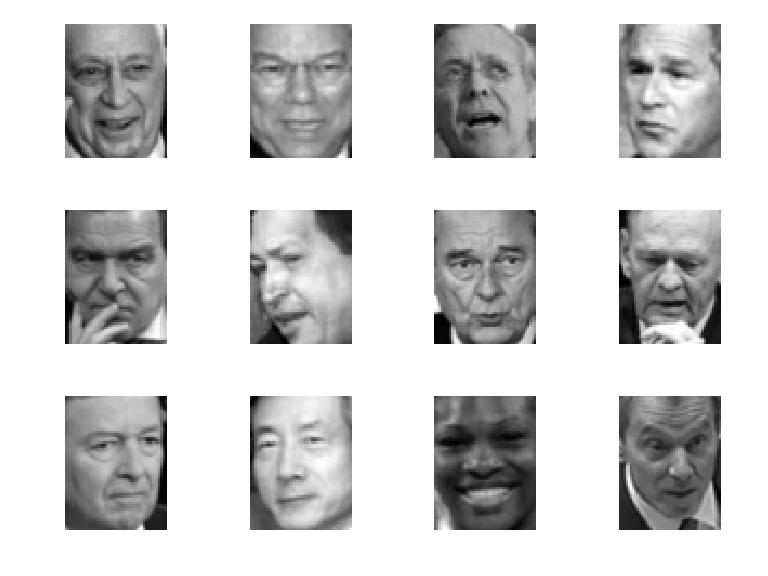

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import datasets

# Load dataset

lfw = datasets.fetch_lfw_people(min_faces_per_person=50)

fig = plt.figure()

# Print sample digits
for i in range(12): 
    plt.subplot(3, 4, i + 1)
    idx=list(lfw.target).index(i)
    plt.imshow(lfw.images[idx], cmap=plt.cm.gray)
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running the learning algorithm.

---

#### Activity 1.        

From the LFW dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `lfw`; the corresponding output data can be accessed as the attribute `target` in `lfw`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to 10% of your data. 

**Note:** Don't forget to import `numpy` and the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number.

---

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
X = lfw.data
y = lfw.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=1)
print(f"Training set (size={len(X_train)})\nFeatures data:\n{X_train}\nTarget/Classes data:\n{y_train}\n")
print(f"\nTest set (size={len(X_test)})\nFeatures data:\n{X_test}\nTarget/Classes data:\n{y_test}\n")

Training set (size=1404)
Features data:
[[123.333336 103.333336 108.666664 ...  52.333332  56.333332  60.333332]
 [ 15.        40.333332  79.666664 ...  28.333334  23.333334  19.333334]
 [102.666664 106.333336 103.666664 ... 247.       247.33333  243.33333 ]
 ...
 [ 62.333332  66.333336  89.       ...  49.        53.        65.      ]
 [134.33333  172.66667  187.33333  ...  83.        83.       102.      ]
 [180.33333  179.66667  179.66667  ...  52.333332  52.        50.666668]]
Target/Classes data:
[ 7 10  3 ...  3  7  6]


Test set (size=156)
Features data:
[[110.666664 110.333336 112.333336 ... 228.33333  229.33333  233.      ]
 [239.66667  236.       192.       ...  84.333336 139.33333  178.66667 ]
 [ 83.666664  97.333336  88.       ... 237.33333  234.66667  126.666664]
 ...
 [107.       115.333336 111.666664 ... 133.66667  125.       111.666664]
 [ 47.666668  54.666668  75.       ... 245.       244.66667  244.33333 ]
 [135.33333  140.       145.66667  ...  90.666664  31.333334  22

Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to 3,000 features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ and can be computed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _normalize_ the data to make sure that all inputs lie in the same range. In our case, since all pixels lie in the same range, normalization is not necessary.

---

PCA model: 
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Cumulative Explained variance of the PCA model
 [ 928932.1 1538595.2 1846397.9 ... 4367901.  4367902.  4367902. ]


<IPython.core.display.Javascript object>


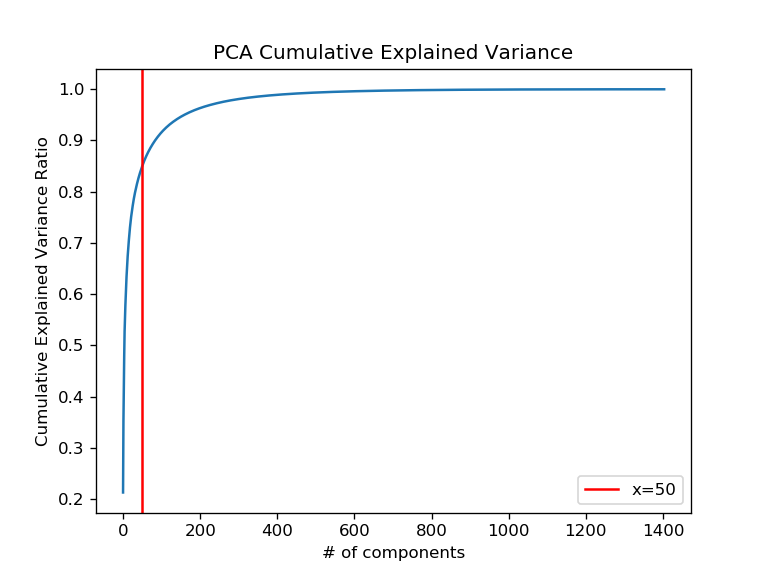

In [26]:
# PCA part
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
X_train_pca = pca.transform(X_train)
print(f"PCA model: \n{pca}")
print(f"\nCumulative Explained variance of the PCA model\n {np.cumsum(pca.explained_variance_)}")
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA Cumulative Explained Variance")
plt.axvline(x=50, color="red", label="x=50")
plt.legend()
plt.show()

Note how 50 components explain almost 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those 50 components as features to represent our data. 

However, to clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{10, 20, ..., 100\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data, with $C=1000$
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 30 times.

** Note: ** The whole process may take a while, so don't despair. The logistic classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
def run_k_pca(c):
    training_errors, validation_errors = [], []
    for i in range(30):
        print(f"Iteration i={i}")
        t_errors, v_errors = [], []
        X_Dt, X_Dv, y_Dt, y_Dv = train_test_split(X_train,y_train,test_size=0.15,random_state=i)
        for k in range(10,101,10):
            k_Dt_pca = PCA(n_components=k).fit(X_Dt)
            k_X_Dt_pca = k_Dt_pca.transform(X_Dt)
            classifier = LogisticRegression(C=c)
            classifier.fit(k_X_Dt_pca, y_Dt)

            k_X_Dv_pca = k_Dt_pca.transform(X_Dv)

            Dt_pred = classifier.predict(k_X_Dt_pca)
            Dv_pred = classifier.predict(k_X_Dv_pca)
            t_errors.append(accuracy_score(y_Dt, Dt_pred))
            v_errors.append(accuracy_score(y_Dv, Dv_pred))
            
        training_errors.append(t_errors)
        validation_errors.append(v_errors)

    np_train_errors = np.array(training_errors)
    np_valid_errors = np.array(validation_errors)
    return np_train_errors, np_valid_errors

act3_train_errors, act3_valid_errors = run_k_pca(1000)

Iteration i=0
Iteration i=1
Iteration i=2
Iteration i=3
Iteration i=4
Iteration i=5
Iteration i=6
Iteration i=7
Iteration i=8
Iteration i=9
Iteration i=10
Iteration i=11
Iteration i=12
Iteration i=13
Iteration i=14
Iteration i=15
Iteration i=16
Iteration i=17
Iteration i=18
Iteration i=19
Iteration i=20
Iteration i=21
Iteration i=22
Iteration i=23
Iteration i=24
Iteration i=25
Iteration i=26
Iteration i=27
Iteration i=28
Iteration i=29


---

#### Activity 4.        

Plot the average training and validation error from Activity 3 as a function of $k$. Comment.

---

<IPython.core.display.Javascript object>


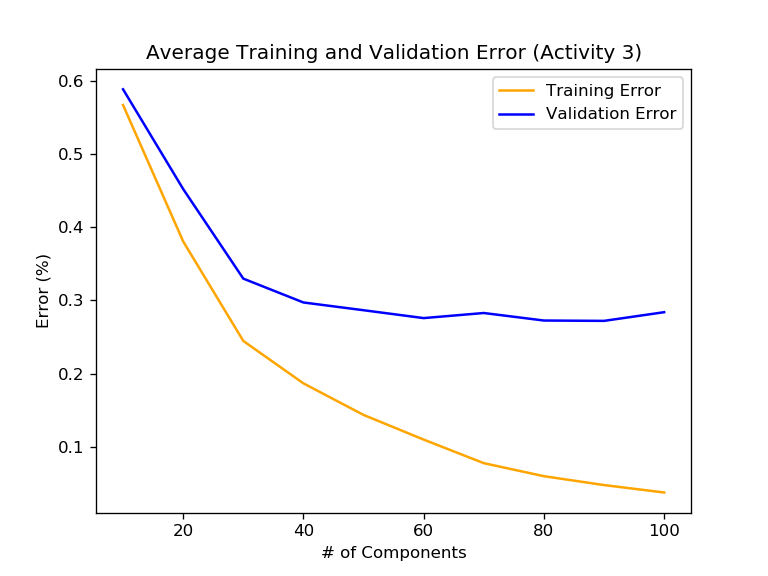

In [28]:
def plot_pca(train_errors, valid_errors, activity, training_color, validation_color):
    plt.figure()
    plt.plot(range(10,101,10), 1 - train_errors.mean(axis=0), label="Training Error", color=training_color)
    plt.plot(range(10,101,10), 1 - valid_errors.mean(axis=0), label="Validation Error", color=validation_color)
    plt.ylabel("Error (%)")
    plt.xlabel("# of Components")
    plt.title(f"Average Training and Validation Error ({activity})")
    plt.legend()
    plt.show()
plot_pca(act3_train_errors, act3_valid_errors, "Activity 3", "orange", "blue")

__Comment__

*__Parameter C__*

O validation error é sempre maior e podemos observar overfit devido ao parâmetro C.  
Para valores elevados de C (neste caso, C = 1000), o algoritmo tenta minimizar ao máximo os erros para o training set, levando ao overfit (a partir de k = 40, o validation error não varia significativamente).

*__Parameter k__* (# of components)

À medida que o k aumenta, podemos observar que o training error e o validation error, visto que existe uma menor perda de informação devido à existência de um maior número de componentes.

__(end of comment)__

As seen in the homework, the logistic regression model is trained to minimize the cost function

$$J(\pi)=-\frac{1}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

However, the logistic regression model in `scikit-learn` uses a slightly different cost function; this modified cost function includes a term that penalizes large values for the parameters $\mathbf{w}$ and takes the general form

$$J(\pi)=\frac{1}{2}\|w\|^2-\frac{C}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

The first term is called a _regularization term_ and the constant $C$ expresses how much we are willing to pay (in terms of errors in the training set) to have small parameter vectors. In activity 3 you used a large value for $C$, indicating the algorithm that errors in the training set should be minimized.

---

#### Activity 5.

Repeat Activity 3 but now setting $C=1$. Plot the results and comment.

---

Iteration i=0
Iteration i=1
Iteration i=2
Iteration i=3
Iteration i=4
Iteration i=5
Iteration i=6
Iteration i=7
Iteration i=8
Iteration i=9
Iteration i=10
Iteration i=11
Iteration i=12
Iteration i=13
Iteration i=14
Iteration i=15
Iteration i=16
Iteration i=17
Iteration i=18
Iteration i=19
Iteration i=20
Iteration i=21
Iteration i=22
Iteration i=23
Iteration i=24
Iteration i=25
Iteration i=26
Iteration i=27
Iteration i=28
Iteration i=29


<IPython.core.display.Javascript object>


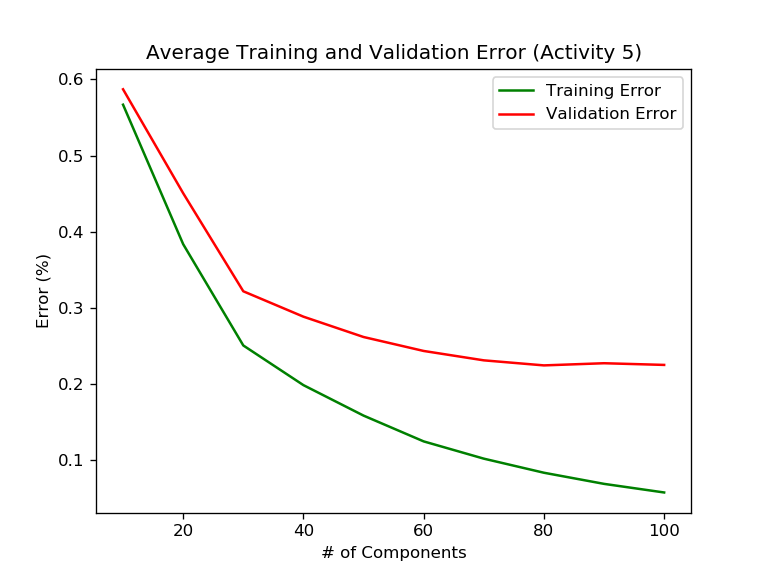

In [29]:
act5_train_errors, act5_valid_errors = run_k_pca(1)
plot_pca(act5_train_errors, act5_valid_errors, "Activity 5", "green", "red")

<IPython.core.display.Javascript object>


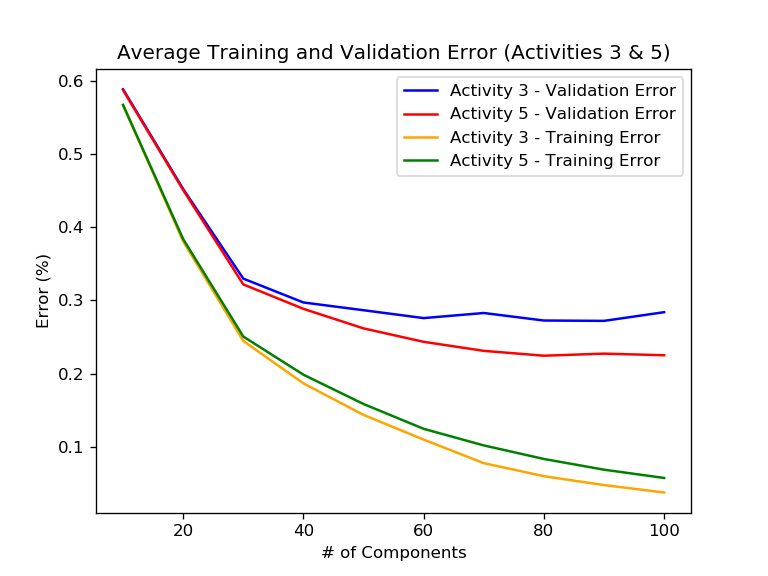

In [30]:
plt.figure()
plt.plot(range(10,101,10), 1 - act3_valid_errors.mean(axis=0), label="Activity 3 - Validation Error", color="blue")
plt.plot(range(10,101,10), 1 - act5_valid_errors.mean(axis=0), label="Activity 5 - Validation Error", color="red")
plt.plot(range(10,101,10), 1 - act3_train_errors.mean(axis=0), label="Activity 3 - Training Error", color="orange")
plt.plot(range(10,101,10), 1 - act5_train_errors.mean(axis=0), label="Activity 5 - Training Error", color="green")
plt.ylabel("Error (%)")
plt.xlabel("# of Components")
plt.title(f"Average Training and Validation Error (Activities 3 & 5)")
plt.legend()
plt.show()

__Comment:__

Podemos verificar que o Training Error da activity 3 é frequentemente mais baixo do que na activity 5.  
Em relação ao validation error, na activity 3 este é sempre maior do que na activity 5.

*__Parameter C__*

Como estamos a utilizar um valor de C mais baixo na actividade 5, o validation error apresenta menos overfit porque o custo dos erros é muito baixo.   
Logo, o algoritmo minimiza pouco os erros para o training set e generaliza melhor (resultando num validation error mais baixo).  

*__Parameter k__* (# of components)

O impacto do k nos resultados é semelhante ao observado na actividade 3.

__(end of comment)__

In light of the results, we can now safely train our classifier with a larger number of components (say, $k=80$) by setting $C=1$ to avoid overfitting.

---

#### Activity 6.

* Retrain your PCA model with $k=80$ components---now using all your training data;
* Retrain the logistic regression model;
* Compute the performance of the resulting model in the test data (don't forget to transform the test data).

In particular, compute both the accuracy score and print the confusion matrix (which you can access from `sklearn.metrics`). Comment the obtained results in face of Activities 3-5.

---


Test Accuracy Score: 0.83
[[ 5  0  0  1  0  0  0  1  0  0  0  0]
 [ 0 20  0  2  0  1  0  1  0  1  0  0]
 [ 1  0  7  1  0  0  0  0  0  0  0  1]
 [ 0  0  1 58  1  0  0  0  1  0  0  0]
 [ 0  0  0  1  6  1  0  0  0  0  0  1]
 [ 0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  1  0  0  0  1]
 [ 1  0  1  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  1]
 [ 0  1  0  0  0  0  1  0  0  6  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  5  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  9]]


<IPython.core.display.Javascript object>


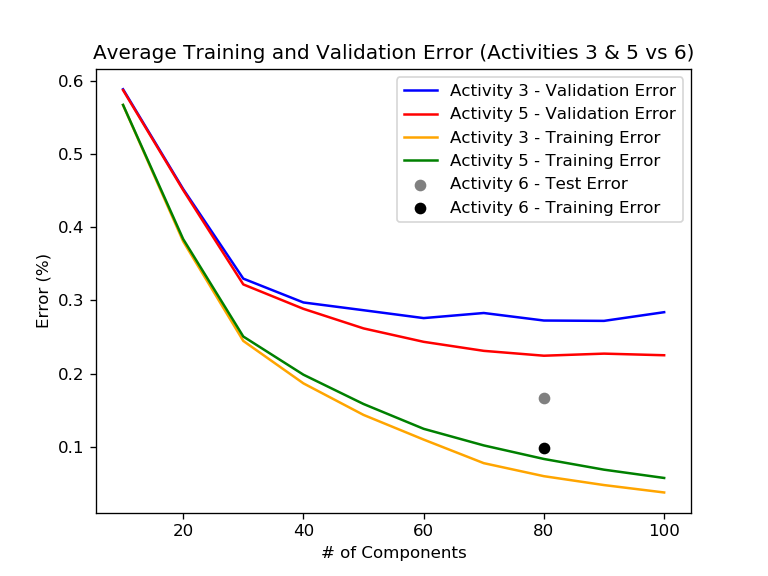

In [32]:
from sklearn.metrics import confusion_matrix
act6_train_pca = PCA(n_components=80).fit(X_train)
X_train_pca = act6_train_pca.transform(X_train)
classifier = LogisticRegression(C=1)
classifier.fit(X_train_pca, y_train)

X_test_pca = act6_train_pca.transform(X_test)

y_train_pred = classifier.predict(X_train_pca)
y_test_pred = classifier.predict(X_test_pca)

print(f"\nTest Accuracy Score: {accuracy_score(y_test, y_test_pred):.2f}")
print(confusion_matrix(y_test,y_test_pred, labels=range(len(set(y)))))

plt.figure()
plt.scatter(80, 1 - accuracy_score(y_test, y_test_pred), label="Activity 6 - Test Error", color="grey")
plt.scatter(80, 1 - accuracy_score(y_train, y_train_pred), label="Activity 6 - Training Error", color="black")
plt.plot(range(10,101,10), 1 - act3_valid_errors.mean(axis=0), label="Activity 3 - Validation Error", color="blue")
plt.plot(range(10,101,10), 1 - act5_valid_errors.mean(axis=0), label="Activity 5 - Validation Error", color="red")
plt.plot(range(10,101,10), 1 - act3_train_errors.mean(axis=0), label="Activity 3 - Training Error", color="orange")
plt.plot(range(10,101,10), 1 - act5_train_errors.mean(axis=0), label="Activity 5 - Training Error", color="green")
plt.ylabel("Error (%)")
plt.xlabel("# of Components")
plt.title(f"Average Training and Validation Error (Activities 3 & 5 vs 6)")
plt.legend()
plt.show()

__Comment__

Podemos observar que os resultados com training/test set original (90/10 split) são semelhantes aos resultados obtidos nas actividades 3 e 5, em particular, na actividade 5 visto que o parametro C é igual (C=1).

*__Better Test Error due to higher amount of data__*  
Devido ao aumento da quantidade de dados no training/test set original relativamente às actividades anteriores, o test error é menor porque o modelo foi gerado com uma maior quantidade de dados do que os modelos gerados nas actividades 3 e 5.

*__Difference between Test Error and Training Error for Activity 6__*

Podemos observar que a diferença entre o test error e o training na actividade 6 é menor do que nas actividades anteriores porque o modelo generalizou melhor através da utilização de uma maior quantidade de dados.

__(end of comment)__